In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pyts.datasets import make_cylinder_bell_funnel

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [3]:
random_state = 0

# IMPORT DATASET

In [4]:
dataset_name = "cbf"

In [5]:
X_all, y_all = make_cylinder_bell_funnel(n_samples = 600, random_state = random_state)
X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))

In [6]:
print("X SHAPE: ", X_all.shape)
print("y SHAPE: ", y_all.shape)
unique, counts = np.unique(y_all, return_counts=True)
print("\nCLASSES BALANCE")
for i, label in enumerate(unique):
    print(label, ": ", round(counts[i]/sum(counts), 2))

X SHAPE:  (600, 128, 1)
y SHAPE:  (600,)

CLASSES BALANCE
0 :  0.33
1 :  0.33
2 :  0.33


## DATASET SPLIT

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# BLACKBOX/EXPLANATION SETS SPLIT
X_train, X_exp, y_train, y_exp = train_test_split(X_all, y_all, 
                                                  test_size=0.3, stratify = y_all, random_state=random_state)

# BLACKBOX TRAIN/TEST SETS SPLIT
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                  test_size=0.2, stratify = y_train, random_state=random_state)

# BLACKBOX TRAIN/VALIDATION SETS SPLIT
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, stratify = y_train, random_state=random_state)

# EXPLANATION TRAIN/TEST SETS SPLIT
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y_exp, 
                                                                    test_size=0.2, 
                                                                    stratify = y_exp, 
                                                                    random_state=random_state)

# EXPLANATION TRAIN/VALIDATION SETS SPLIT
X_exp_train, X_exp_val, y_exp_train, y_exp_val = train_test_split(X_exp_train, y_exp_train, 
                                                                  test_size=0.2, 
                                                                  stratify = y_exp_train, 
                                                                  random_state=random_state)

print("SHAPES:")
print("BLACKBOX TRAINING SET: ", X_train.shape)
print("BLACKBOX VALIDATION SET: ", X_val.shape)
print("BLACKBOX TEST SET: ", X_test.shape)
print("EXPLANATION TRAINING SET: ", X_exp_train.shape)
print("EXPLANATION VALIDATION SET: ", X_exp_val.shape)
print("EXPLANATION TEST SET: ", X_exp_test.shape)

SHAPES:
BLACKBOX TRAINING SET:  (268, 128, 1)
BLACKBOX VALIDATION SET:  (68, 128, 1)
BLACKBOX TEST SET:  (84, 128, 1)
EXPLANATION TRAINING SET:  (115, 128, 1)
EXPLANATION VALIDATION SET:  (29, 128, 1)
EXPLANATION TEST SET:  (36, 128, 1)


In [9]:
n_timesteps, n_outputs, n_features = X_train.shape[1], len(np.unique(y_all)), 1 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  128
N. LABELS:  3


# BLACKBOX MODEL

In [10]:
from joblib import load
import keras
"""import importlib
importlib.reload(blackboxes)"""
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import time
import blackboxes
from blackboxes import *

Using TensorFlow backend.


## resnet

In [11]:
blackbox = build_resnet(n_timesteps, n_outputs)
blackbox.load_weights(parentdir + "/blackbox_checkpoints/cbf_blackbox_resnet_20191106_145242_best_weights_+1.00_.hdf5")
resnet = blackbox

## simple CNN

In [12]:
blackbox = build_simple_CNN(n_timesteps, n_outputs)
blackbox.load_weights(parentdir + "/blackbox_checkpoints/cbf_blackbox_simpleCNN_20191106_145515_best_weights_+1.00_.hdf5")
simplecnn = blackbox

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [14]:
knn = load(parentdir + "/blackbox_checkpoints/cbf_blackbox_knn_20191106_145654.joblib")

# AUTOENCODER

In [15]:
"""import importlib
importlib.reload(autoencoders)"""
import autoencoders
from autoencoders import *

## Standard

In [16]:
params = {"input_shape": (n_timesteps,1),
          "n_blocks": 8, 
          "latent_dim": 2,
          "encoder_latent_layer_type": "dense",
          "encoder_args": {"filters":[2,4,8,16,32,64,128,256], 
                            "kernel_size":[21,18,15,13,11,8,5,3], 
                            "padding":"same", 
                            "activation":"elu", 
                            "pooling":[1,1,1,1,1,1,1,1]}
         }

aut = Autoencoder(verbose = False, **params)
encoder, decoder, autoencoder = aut.build()
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/cbf_autoencoder_20191106_144056_best_weights_+1.0504_.hdf5")
ae = autoencoder

## VARIATIONAL

In [17]:
params = {"input_shape": (n_timesteps,1),
          "n_blocks": 8, 
          "latent_dim": 2,
          "encoder_latent_layer_type": "variational",
          "encoder_args": {"filters":[2,4,8,16,32,64,128,256], 
                            "kernel_size":[21,18,15,13,11,8,5,3], 
                            "padding":"same", 
                            "activation":"elu", 
                            "pooling":[1,1,1,1,1,1,1,1]}
         }

aut = Autoencoder(verbose = False, **params)
encoder, decoder, autoencoder = aut.build()
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/cbf_autoencoder_20191106_144909_best_weights_+136.8745_.hdf5")
vae = autoencoder

## DISCRIMINATIVE STANDARD

In [18]:
params = {"input_shape": (n_timesteps,1),
          "n_blocks": 8, 
          "latent_dim": 2,
          "encoder_latent_layer_type": "dense",
          "encoder_args": {"filters":[2, 4,8,16,32,64,128,256], 
                            "kernel_size":[21,18,15,13,11,8,5,3], 
                            "padding":"same", 
                            "activation":"elu", 
                            "pooling":[1,1,1,1,1,1,1,1]},
          "discriminator_args": {"units": [100,100],
                                 "activation": "relu"},
          "n_blocks_discriminator": 2
         }

aut = DiscriminativeAutoencoder(verbose = False, **params)
encoder, decoder, discriminator, autoencoder = aut.build()
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/cbf_autoencoder_20191106_150722_best_weights_+1.239848_.hdf5")
dae = autoencoder

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## DISCRIMINATIVE VARIATIONAL

In [19]:
params = {"input_shape": (n_timesteps,1),
          "n_blocks": 8, 
          "latent_dim": 2,
          "encoder_latent_layer_type": "variational",
          "encoder_args": {"filters":[2, 4,8,16,32,64,128,256], 
                            "kernel_size":[21,18,15,13,11,8,5,3], 
                            "padding":"same", 
                            "activation":"elu", 
                            "pooling":[1,1,1,1,1,1,1,1]},
          "discriminator_args": {"units": [100,100],
                                 "activation": "relu"},
          "n_blocks_discriminator": 2
         }

aut = DiscriminativeAutoencoder(verbose = False, **params)
encoder, decoder, discriminator, autoencoder = aut.build()
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/cbf_autoencoder_20191106_153613_best_weights_+1.179660_.hdf5")
dvae = autoencoder

# NEIGHBORHOOD GENERATION

In [20]:
import agnosticlocalexplainer
from agnosticlocalexplainer import *
import importlib
importlib.reload(agnosticlocalexplainer)

/Users/francesco/anaconda3/envs/tesi/lib/python3.6/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


<module 'agnosticlocalexplainer' from '/Users/francesco/github/TS_AgnosticLocalExplainer/agnosticlocalexplainer.py'>

In [21]:
autoencoder = vae

In [22]:
index_to_explain = 1

## RESNET

In [23]:
blackbox = resnet

In [25]:
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]

In [26]:
agnostic = AgnosticLocalExplainer(blackbox, 
                                  encoder, 
                                  decoder, 
                                  autoencoder,  
                                  X_explanation = X_exp_test, 
                                  y_explanation = y_exp_test, 
                                  index_to_explain = index_to_explain,
                                  blackbox_input_dimensions = 3,
                                  labels = ["cylinder", "bell", "funnel"]
                                 )
agnostic.check_autoencoder_blackbox_consistency()

original class == reconstructed class --->  True
Class:  cylinder (0)


In [27]:
agnostic.LOREM_neighborhood_generation(
                          neigh_type = 'rndgen', 
                          categorical_use_prob = True,
                          continuous_fun_estimation = False, 
                          size = 500,
                          ocr = 0.1, 
                          multi_label=False,
                          one_vs_rest=False,
                          verbose = True,
                          ngen = 10)


calculating feature values
gen	nevals	avg     	min     	max     
0  	125   	0.496654	0.496654	0.496654
1  	102   	0.544194	0.0739936	0.993307
2  	103   	0.657361	0.0252119	0.993307
3  	105   	0.730347	0.146629 	0.993307
4  	108   	0.843948	0.00831705	0.993307
5  	104   	0.861394	0.0527133 	0.993307
6  	112   	0.882497	0.347267  	0.993307
7  	105   	0.853243	0.10016   	0.993307
8  	103   	0.815193	0.0389605 	0.993307
9  	111   	0.818191	0.0991768 	0.993307
10 	103   	0.873749	0.140999  	0.993307
gen	nevals	avg	min	max
0  	125   	0.5	0.5	0.5
1  	104   	0.604748	0.499172	0.993304
2  	108   	0.753761	0.498881	0.993304
3  	113   	0.873248	0.498031	0.993307
4  	110   	0.881828	0.496753	0.993307
5  	103   	0.922319	0.495246	0.993307
6  	105   	0.936359	0.497233	0.993307
7  	113   	0.946479	0.498537	0.993307
8  	102   	0.925294	0.497893	0.993307
9  	103   	0.938932	0.496796	0.993307
10 	111   	0.953688	0.497888	0.993307
synthetic neighborhood class counts {0: 153, 1: 67, 2: 303}


In [28]:
agnostic.LOREM_tree_rules_extraction()

learning local decision tree
retrieving explanation


In [29]:
agnostic.build_rules_dataframes()

N.RULES =  1
N.COUNTERFACTUAL =  1


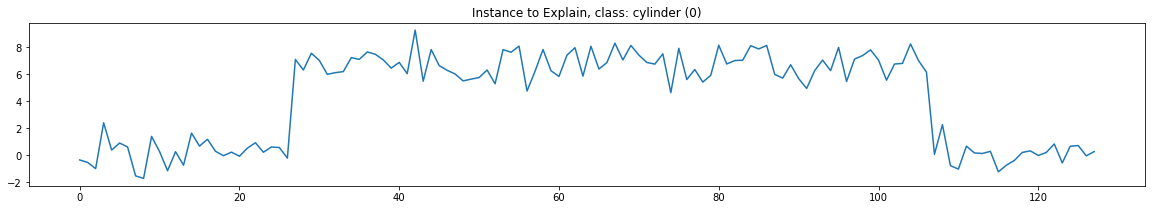

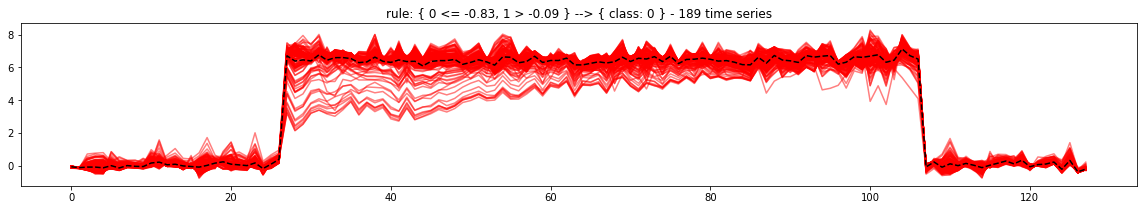

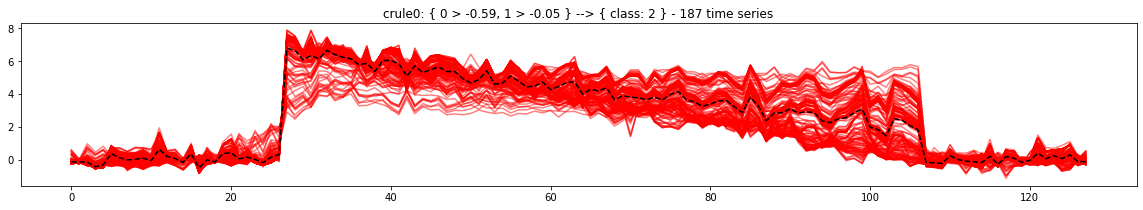

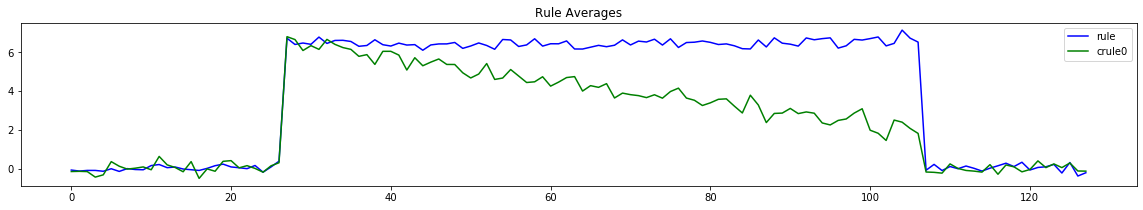

rule


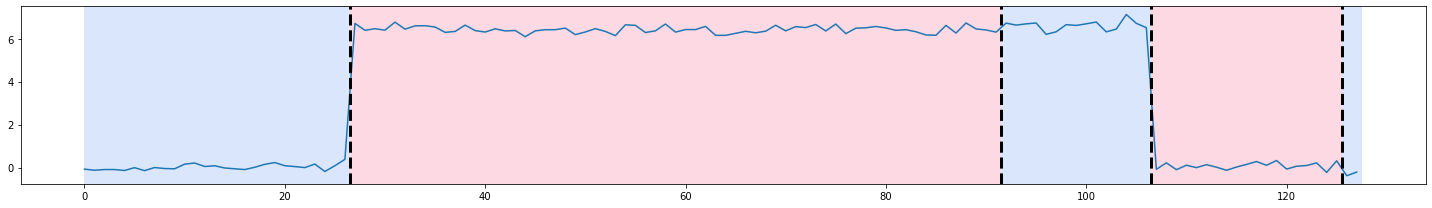

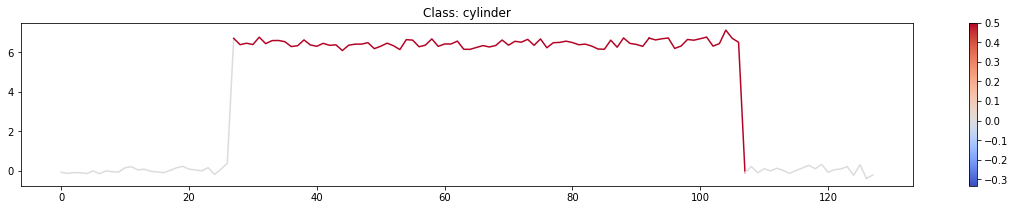

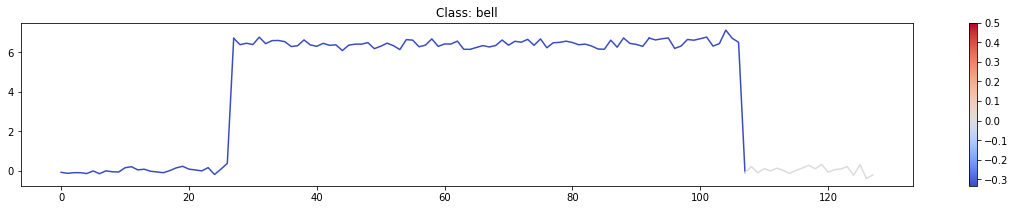

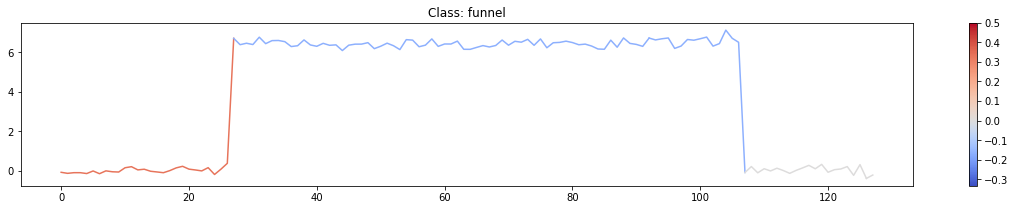

crule0


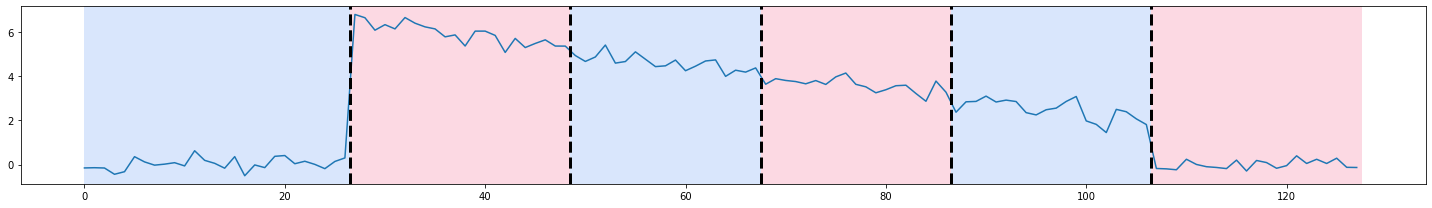

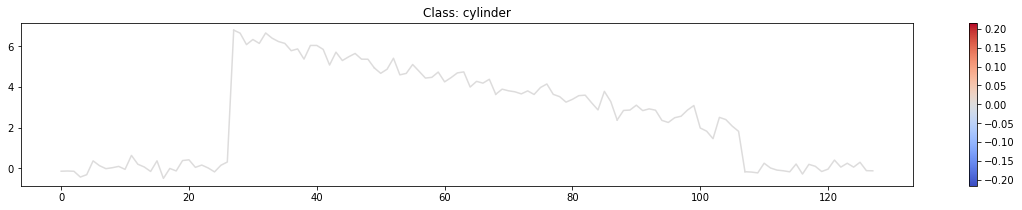

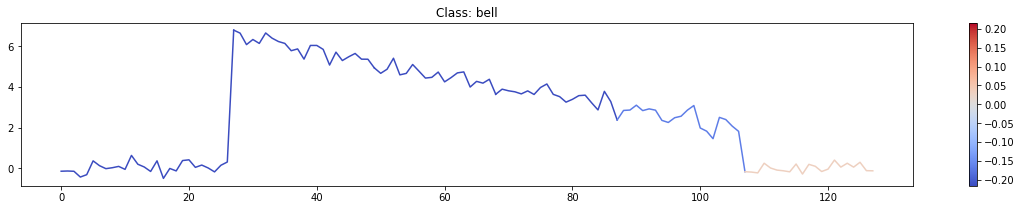

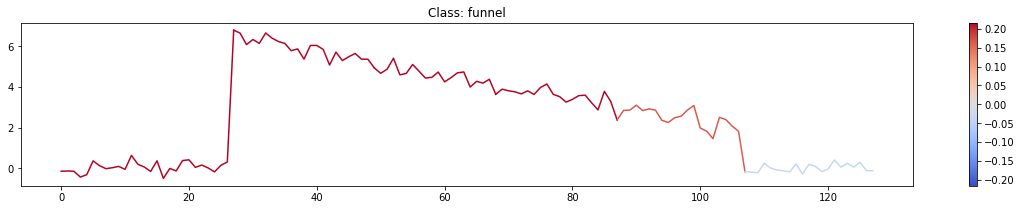



Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.3s finished


rule
Rules used to predict sample 0: 
sample predicted class:  cylinder
decision id node 0 : (shapelet n. 6 (distance = 6.565173) > 2.2295024394989014)


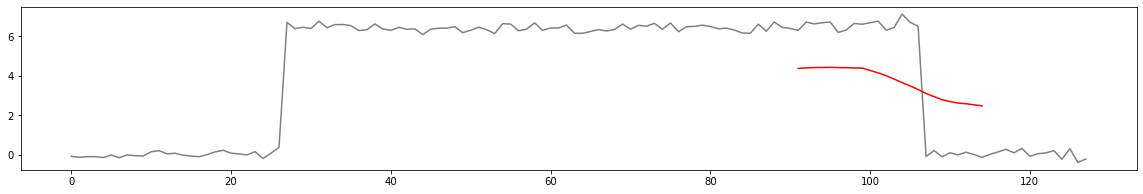

decision id node 0 : (shapelet n. 6 (distance = 6.565173) > 2.2295024394989014)


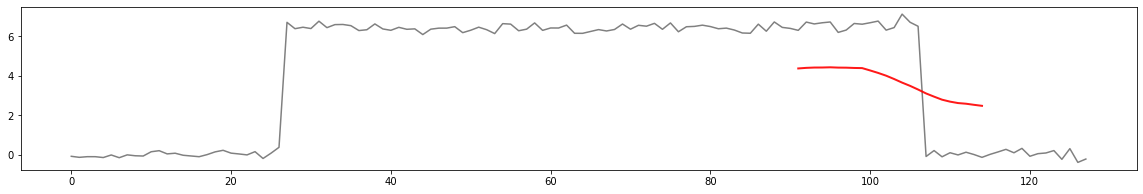

crule0
Rules used to predict sample 0: 
sample predicted class:  funnel
decision id node 0 : (shapelet n. 6 (distance = 0.25361633) <= 2.2295024394989014)
decision id node 1 : (shapelet n. 6 (distance = 0.25361633) <= 1.2238630056381226)
decision id node 2 : (shapelet n. 8 (distance = 1.499934) <= 3.008705258369446)


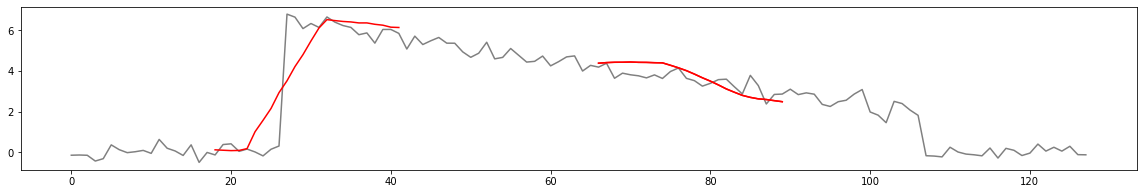

decision id node 0 : (shapelet n. 6 (distance = 0.25361633) <= 2.2295024394989014)


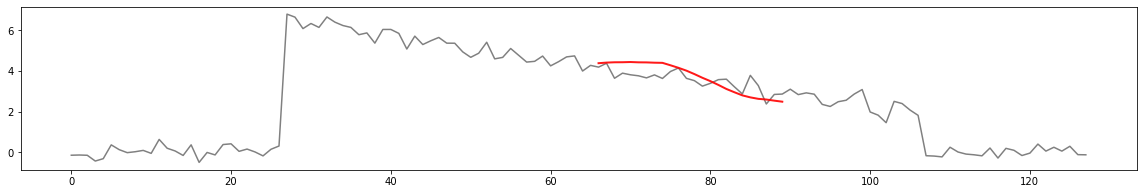

decision id node 1 : (shapelet n. 6 (distance = 0.25361633) <= 1.2238630056381226)


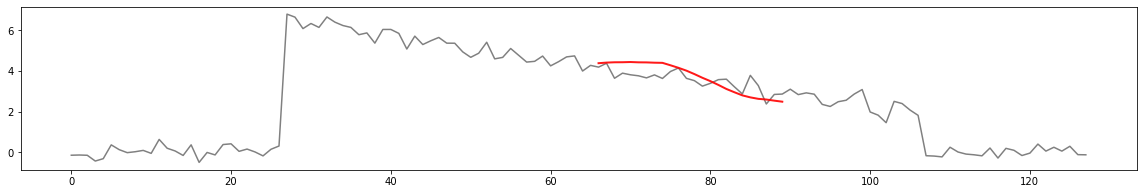

decision id node 2 : (shapelet n. 8 (distance = 1.499934) <= 3.008705258369446)


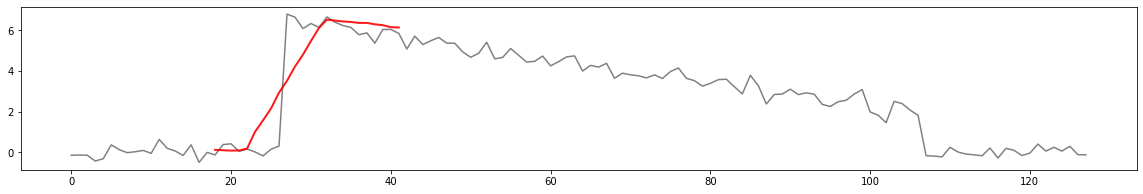

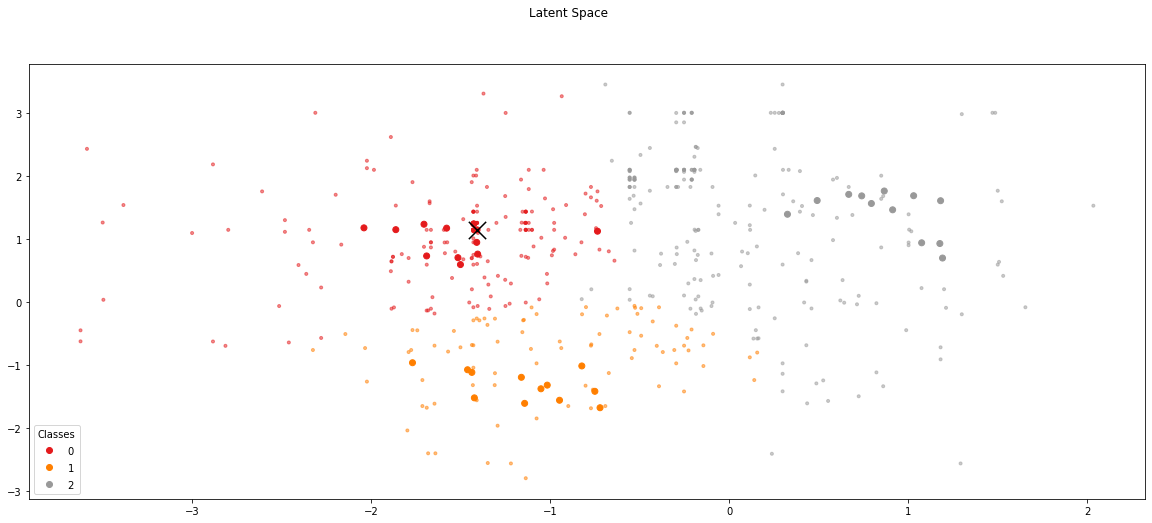

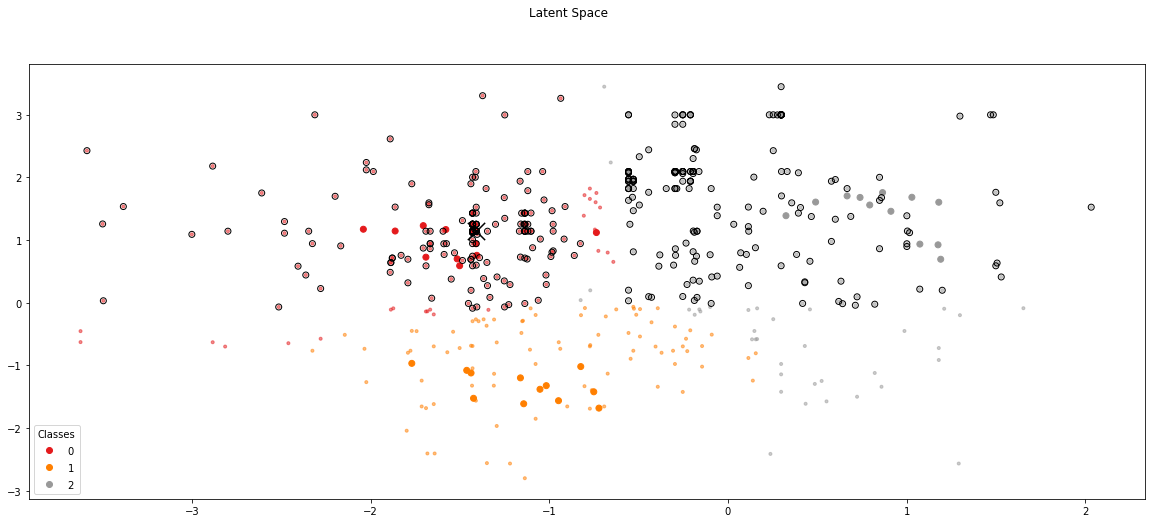

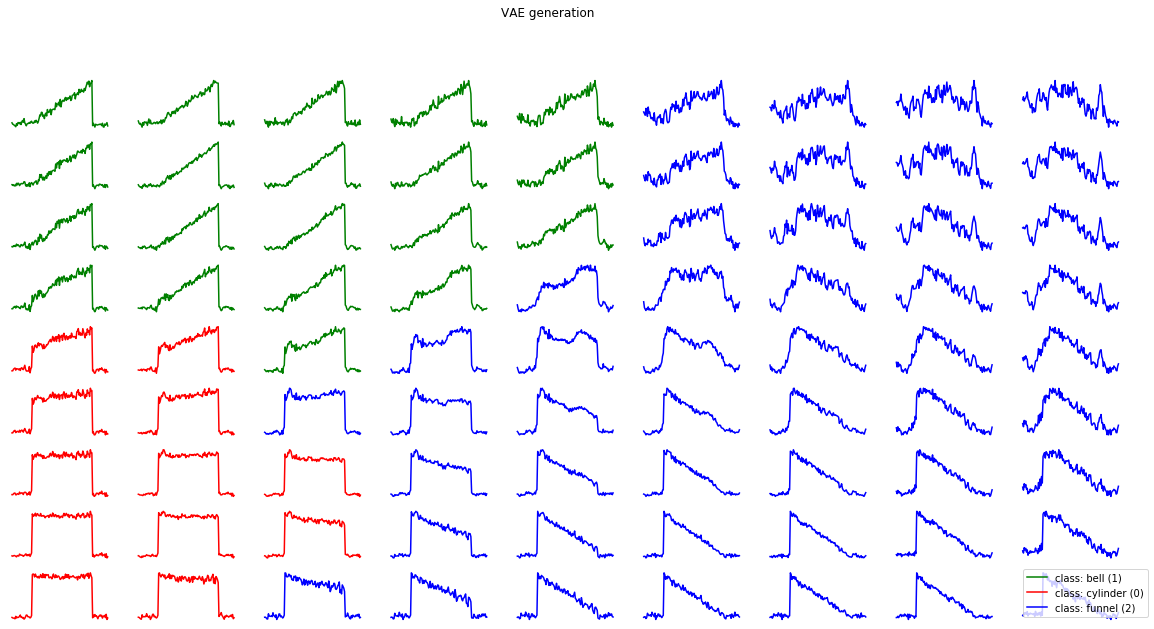

In [29]:
params = {"nsamples":1000, 
          "background":"linear_consecutive", 
          "pen":1, 
          "peltmodel":"rbf",
          "jump": 1,
          "graph_out_file":None,
          "shapelet_mapper":None, 
          "VAE_2d_grid_size":9,
          "max_iter":100}
agnostic.plot_explanation(rules = True,
                          heatmap = False,
                          shap_explanation = True,
                          shapelet_explanation = True,
                          figsize = (20,3),
                          VAE_2d = True,
                          **params
                         )

## SIMPLECNN

In [30]:
blackbox = simplecnn

In [31]:
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]

In [32]:
agnostic = AgnosticLocalExplainer(blackbox, 
                                  encoder, 
                                  decoder, 
                                  autoencoder,  
                                  X_explanation = X_exp_test, 
                                  y_explanation = y_exp_test, 
                                  index_to_explain = index_to_explain,
                                  blackbox_input_dimensions = 3,
                                  labels = ["cylinder", "bell", "funnel"]
                                 )
agnostic.check_autoencoder_blackbox_consistency()

original class == reconstructed class --->  True
Class:  cylinder (0)


In [33]:
agnostic.LOREM_neighborhood_generation(
                          neigh_type = 'rndgen', 
                          categorical_use_prob = True,
                          continuous_fun_estimation = False, 
                          size = 500,
                          ocr = 0.1, 
                          multi_label=False,
                          one_vs_rest=False,
                          verbose = True,
                          ngen = 10)


calculating feature values
gen	nevals	avg     	min     	max     
0  	125   	0.496654	0.496654	0.496654
1  	102   	0.558087	0.00928383	0.993307
2  	103   	0.701928	0.0117904 	0.993307
3  	105   	0.800866	0.0113242 	0.993307
4  	108   	0.880178	0.00689391	0.993307
5  	104   	0.860203	0.00671224	0.993307
6  	112   	0.878616	0.0532774 	0.993307
7  	105   	0.884034	0.010203  	0.993307
8  	103   	0.886   	0.00675689	0.993307
9  	111   	0.831019	0.00923787	0.993307
10 	103   	0.899586	0.00750846	0.993307
gen	nevals	avg	min	max
0  	125   	0.5	0.5	0.5
1  	104   	0.558827	0.493998	0.993283
2  	108   	0.624085	0.493691	0.993283
3  	113   	0.731211	0.493011	0.993283
4  	110   	0.795218	0.496272	0.993283
5  	103   	0.882755	0.494207	0.993249
6  	105   	0.855714	0.496453	0.993272
7  	113   	0.90724 	0.491404	0.993307
8  	102   	0.894408	0.495156	0.993307
9  	103   	0.881736	0.492683	0.993307
10 	111   	0.899436	0.494768	0.993307
synthetic neighborhood class counts {0: 217, 1: 129, 2: 177}


In [34]:
agnostic.LOREM_tree_rules_extraction()

learning local decision tree
retrieving explanation


In [35]:
agnostic.build_rules_dataframes()

N.RULES =  1
N.COUNTERFACTUAL =  1


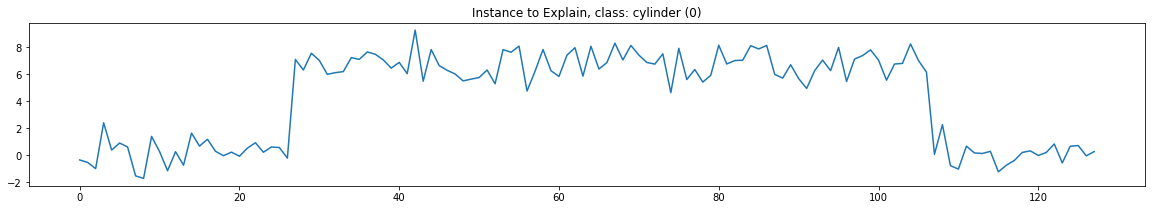

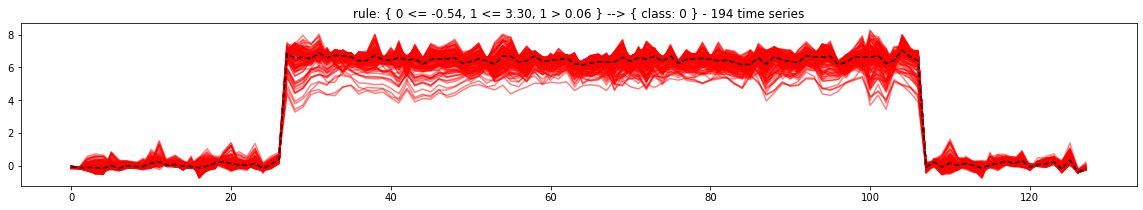

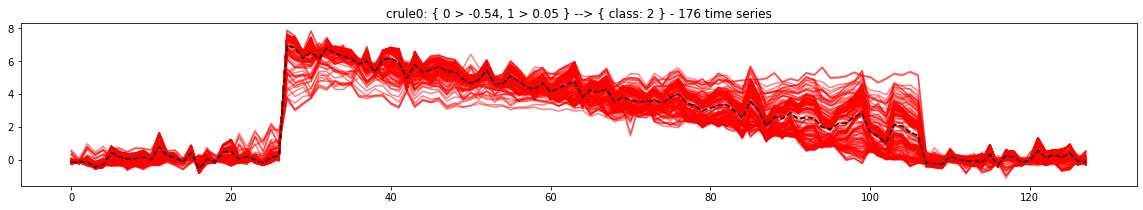

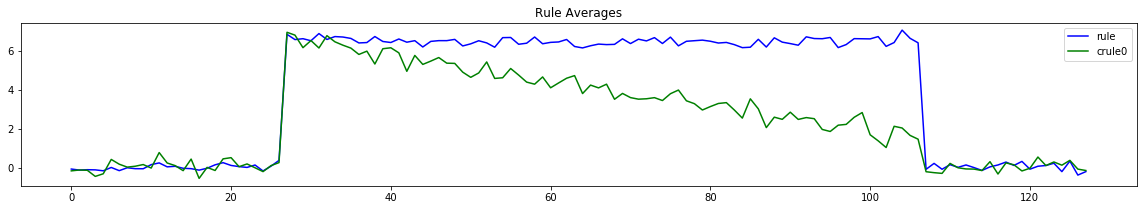

rule


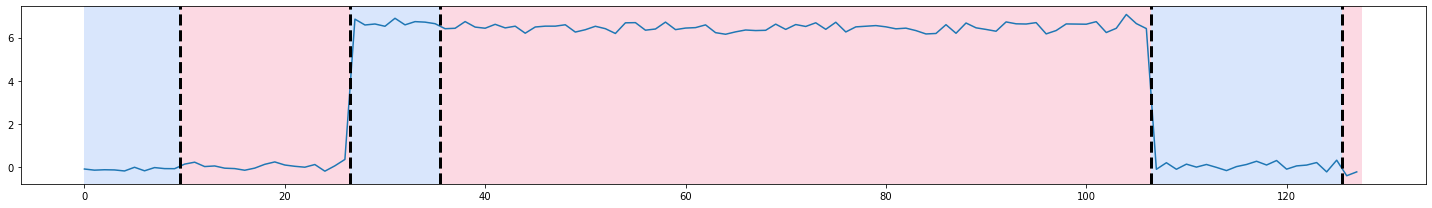

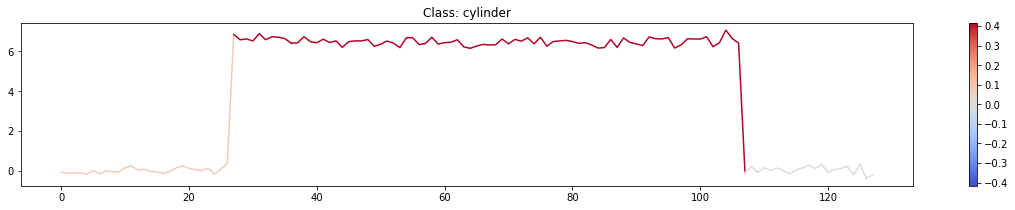

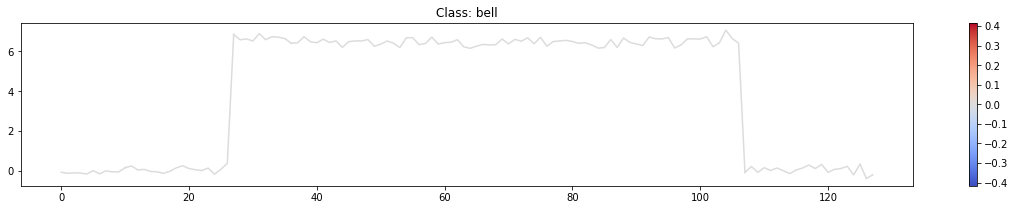

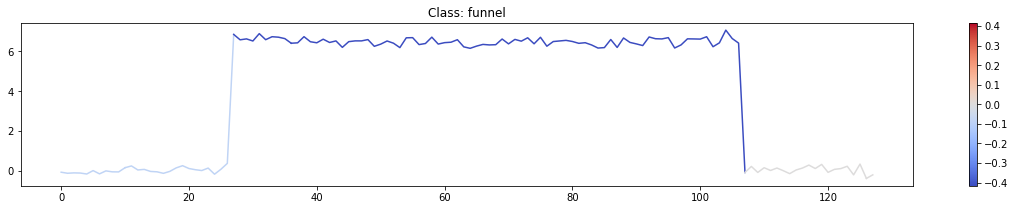

crule0


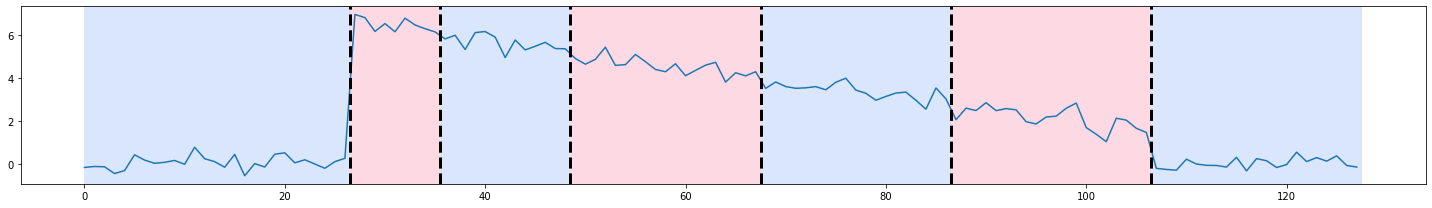

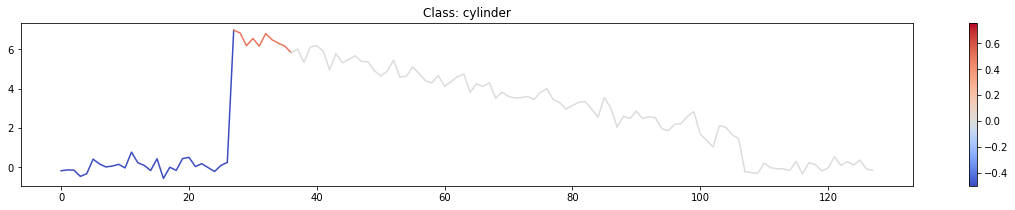

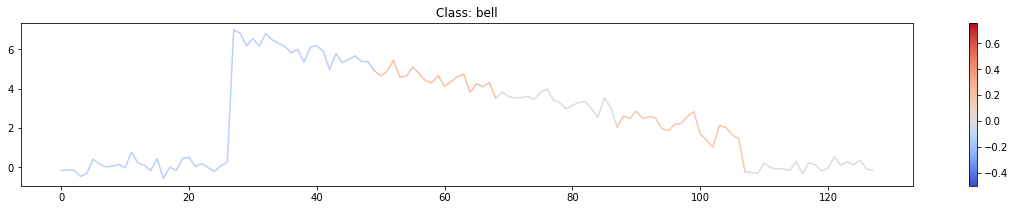

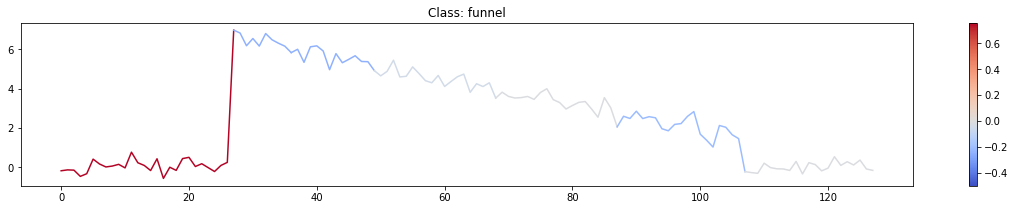

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.9s finished


rule
Rules used to predict sample 0: 
sample predicted class:  cylinder
decision id node 0 : (shapelet n. 0 (distance = 8.619212) > 1.0438640117645264)
decision id node 20 : (shapelet n. 1 (distance = 0.06604513) <= 0.29037730395793915)


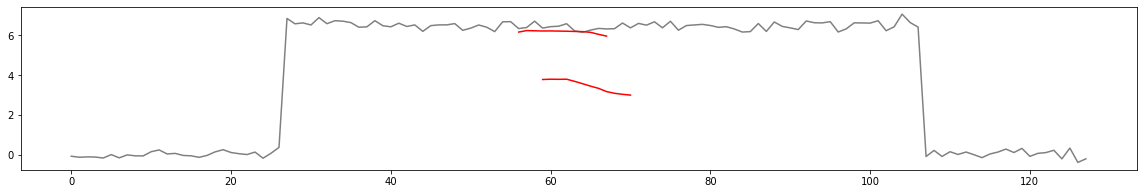

decision id node 0 : (shapelet n. 0 (distance = 8.619212) > 1.0438640117645264)


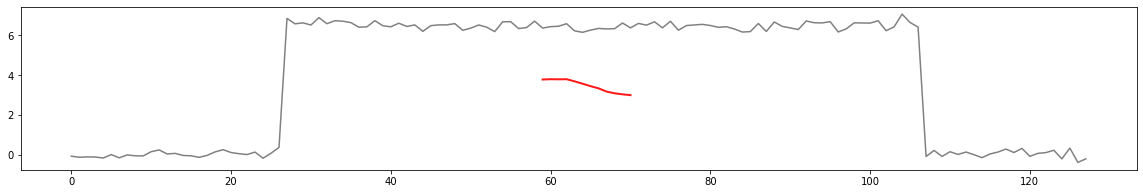

decision id node 20 : (shapelet n. 1 (distance = 0.06604513) <= 0.29037730395793915)


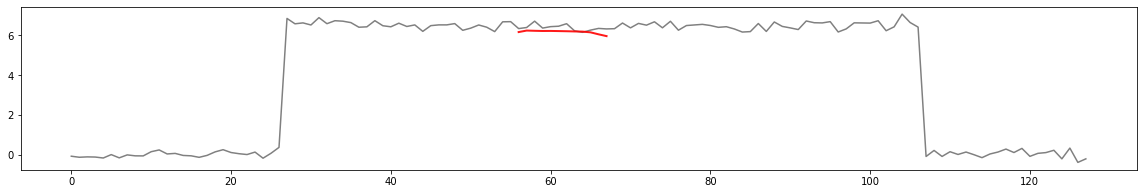

crule0
Rules used to predict sample 0: 
sample predicted class:  funnel
decision id node 0 : (shapelet n. 0 (distance = 0.05230459) <= 1.0438640117645264)
decision id node 1 : (shapelet n. 3 (distance = 1.3642883) <= 3.1068217754364014)
decision id node 2 : (shapelet n. 9 (distance = 2.0730262) <= 2.902347683906555)


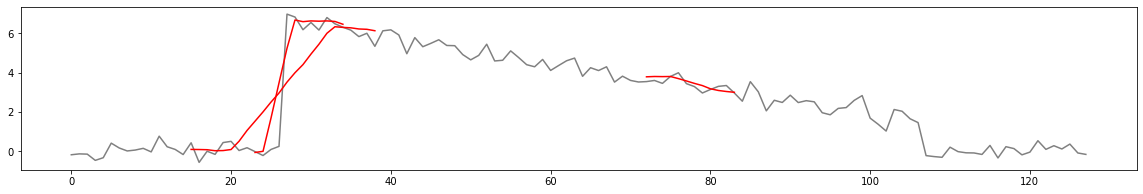

decision id node 0 : (shapelet n. 0 (distance = 0.05230459) <= 1.0438640117645264)


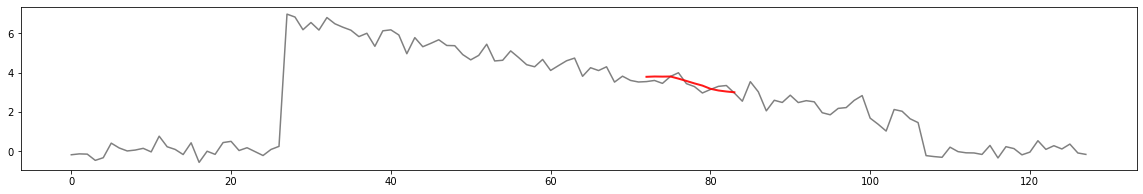

decision id node 1 : (shapelet n. 3 (distance = 1.3642883) <= 3.1068217754364014)


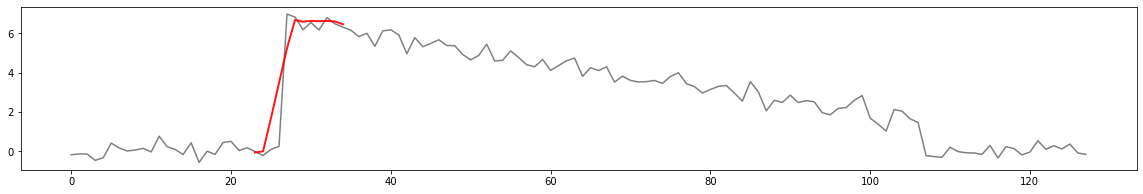

decision id node 2 : (shapelet n. 9 (distance = 2.0730262) <= 2.902347683906555)


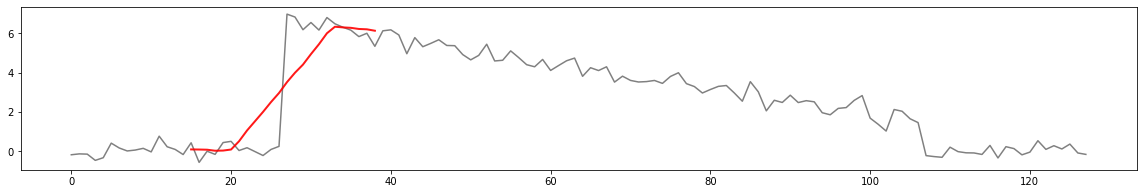

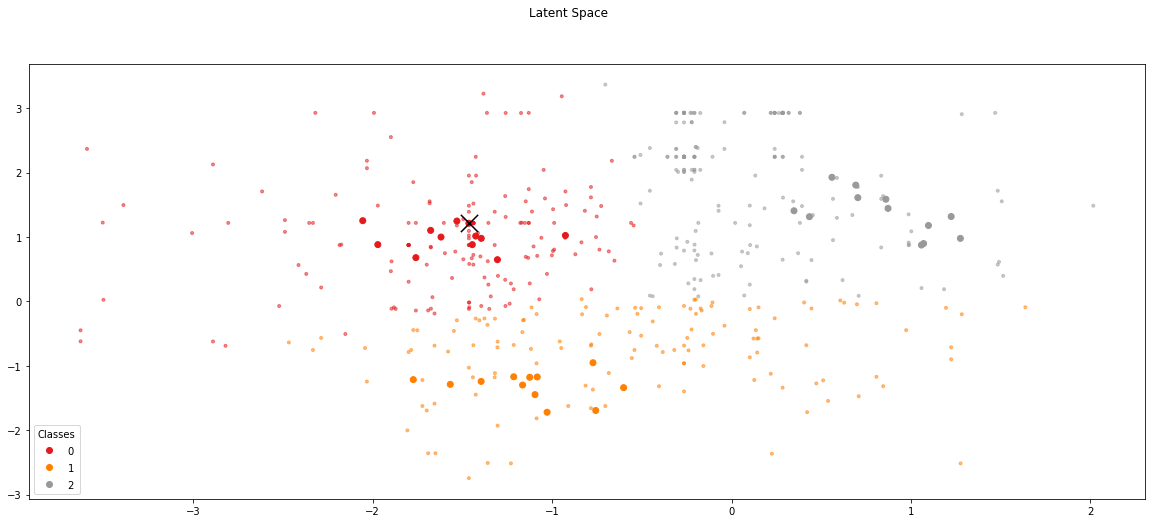

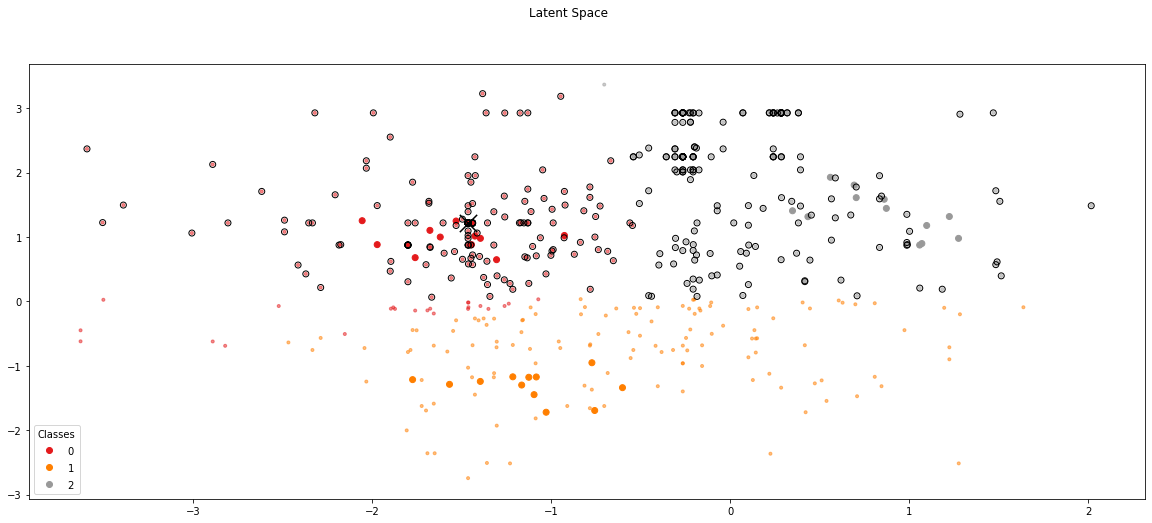

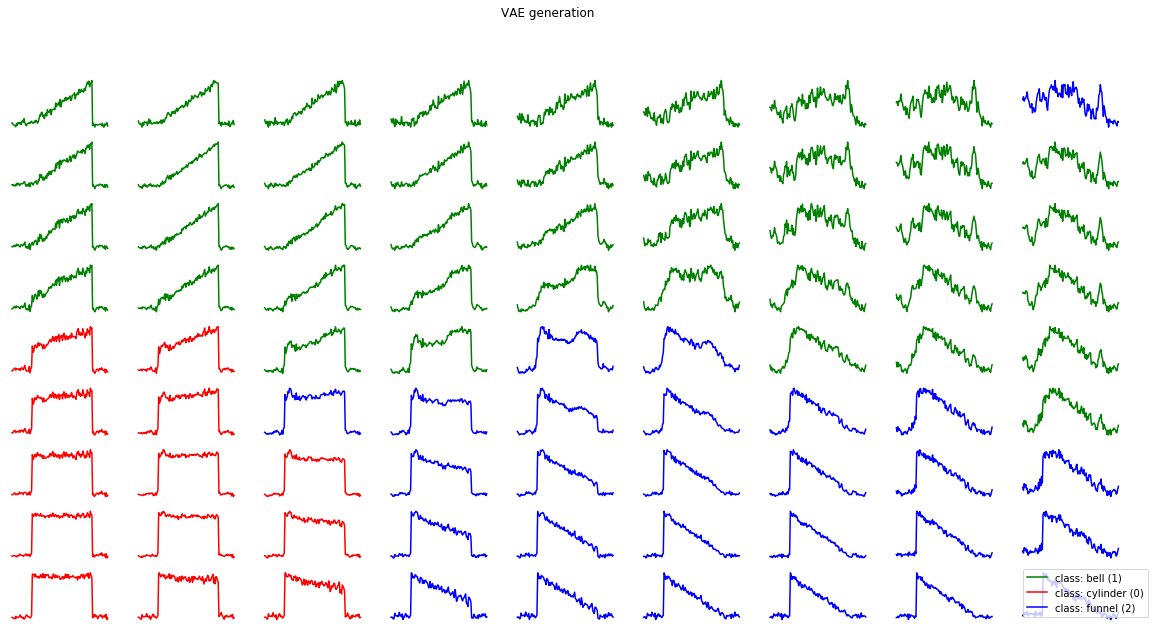

In [36]:
params = {"nsamples":1000, 
          "background":"linear_consecutive", 
          "pen":1, 
          "peltmodel":"rbf",
          "jump": 1,
          "graph_out_file":None,
          "shapelet_mapper":None, 
          "VAE_2d_grid_size":9,
          "max_iter":100}
agnostic.plot_explanation(rules = True,
                          heatmap = False,
                          shap_explanation = True,
                          shapelet_explanation = True,
                          figsize = (20,3),
                          VAE_2d = True,
                          **params
                         )

## KNN

In [37]:
blackbox = knn

In [38]:
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]

In [39]:
agnostic = AgnosticLocalExplainer(blackbox, 
                                  encoder, 
                                  decoder, 
                                  autoencoder,  
                                  X_explanation = X_exp_test, 
                                  y_explanation = y_exp_test, 
                                  index_to_explain = index_to_explain,
                                  blackbox_input_dimensions = 2,
                                  labels = ["cylinder", "bell", "funnel"]
                                 )
agnostic.check_autoencoder_blackbox_consistency()

original class == reconstructed class --->  True
Class:  cylinder (0)


In [40]:
agnostic.LOREM_neighborhood_generation(
                          neigh_type = 'rndgen', 
                          categorical_use_prob = True,
                          continuous_fun_estimation = False, 
                          size = 500,
                          ocr = 0.1, 
                          multi_label=False,
                          one_vs_rest=False,
                          verbose = True,
                          ngen = 10)


calculating feature values
gen	nevals	avg     	min     	max     
0  	125   	0.496654	0.496654	0.496654
1  	102   	0.550906	0.00936953	0.993307
2  	103   	0.703022	0.0121959 	0.993307
3  	105   	0.794032	0.0112106 	0.993307
4  	108   	0.87958 	0.00692595	0.993307
5  	104   	0.868964	0.00673147	0.993307
6  	112   	0.871365	0.0593844 	0.993307
7  	105   	0.900129	0.0101175 	0.993307
8  	103   	0.88786 	0.00676177	0.993307
9  	111   	0.829417	0.0091402 	0.993307
10 	103   	0.884046	0.00772787	0.993307
gen	nevals	avg	min	max
0  	125   	0.5	0.5	0.5
1  	104   	0.562428	0.494324	0.993249
2  	108   	0.628563	0.462851	0.993249
3  	113   	0.73812 	0.488754	0.993249
4  	110   	0.765298	0.495878	0.993279
5  	103   	0.862914	0.493765	0.993269
6  	105   	0.847392	0.480362	0.993297
7  	113   	0.862323	0.485506	0.993304
8  	102   	0.867673	0.494267	0.993304
9  	103   	0.862419	0.492078	0.993304
10 	111   	0.882859	0.494267	0.993307
synthetic neighborhood class counts {0: 214, 1: 136, 2: 173}


In [41]:
agnostic.LOREM_tree_rules_extraction()

learning local decision tree
retrieving explanation


In [42]:
agnostic.build_rules_dataframes()

N.RULES =  1
N.COUNTERFACTUAL =  1


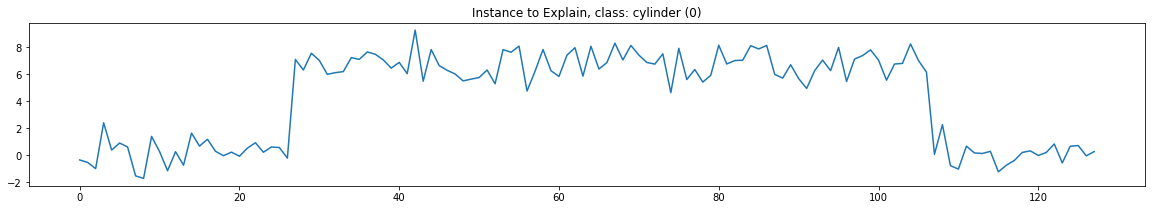

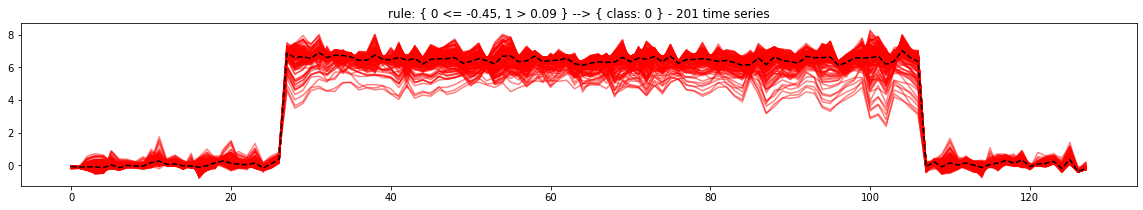

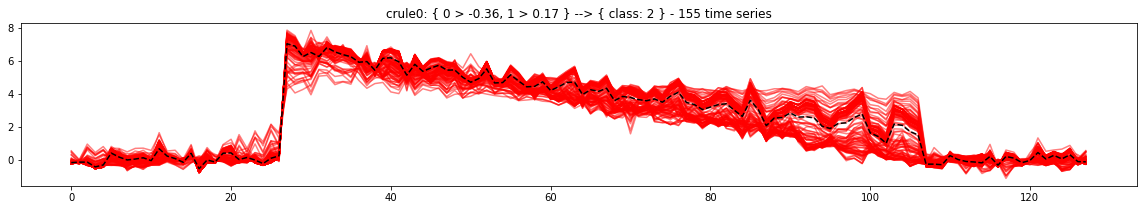

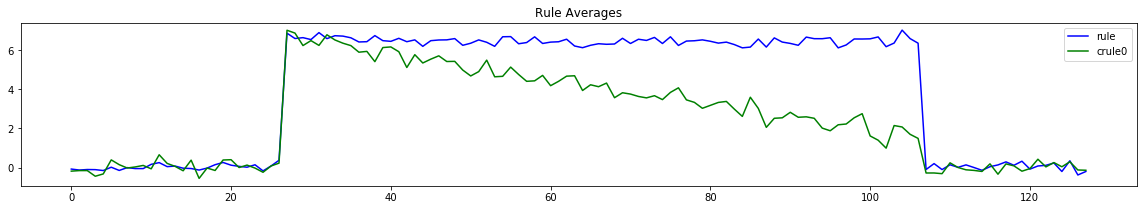

rule


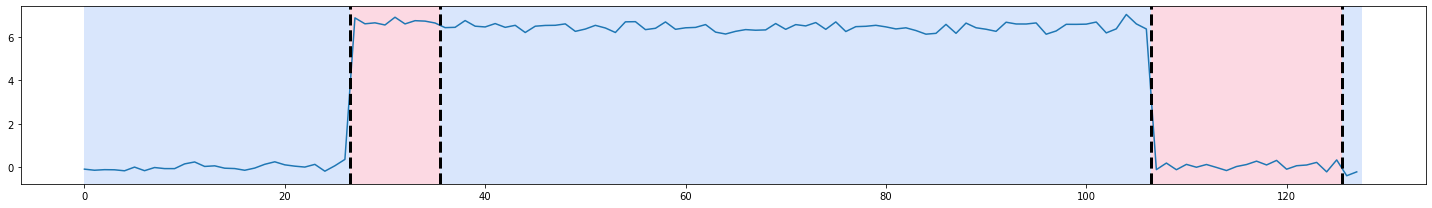

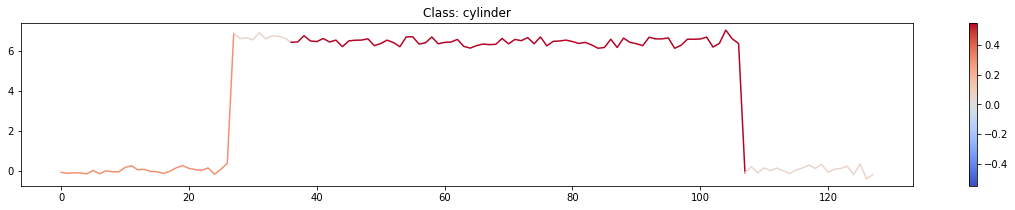

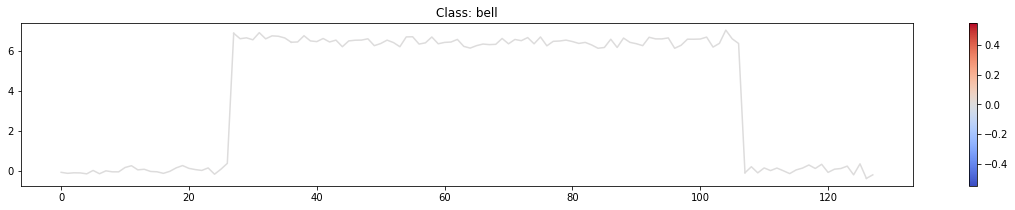

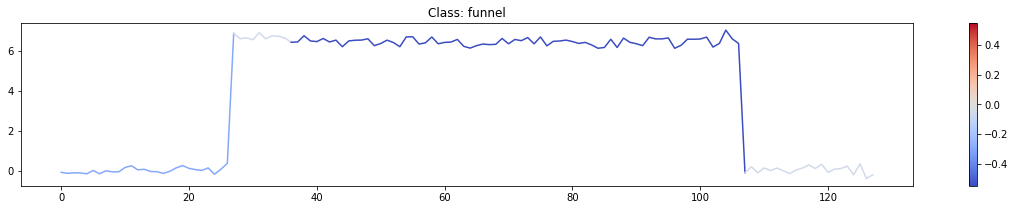

crule0


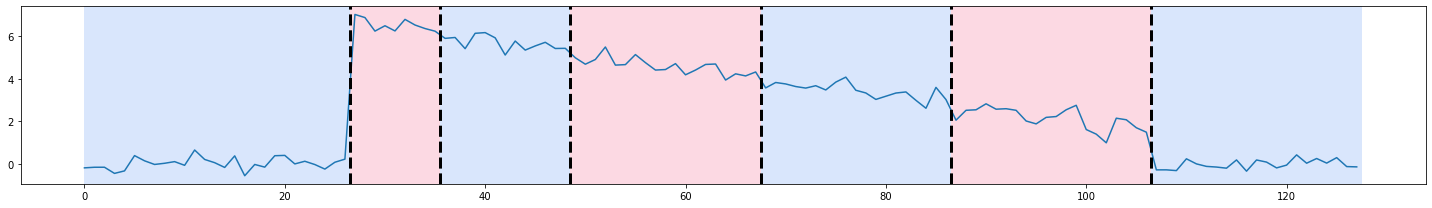

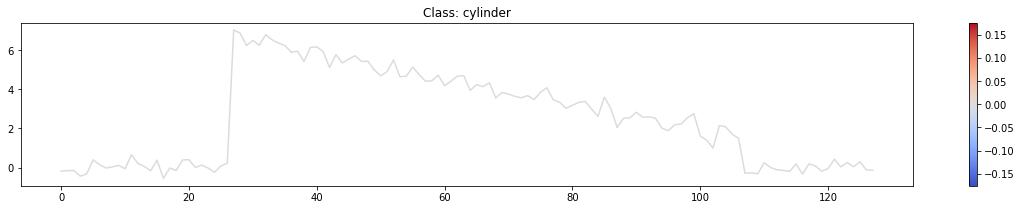

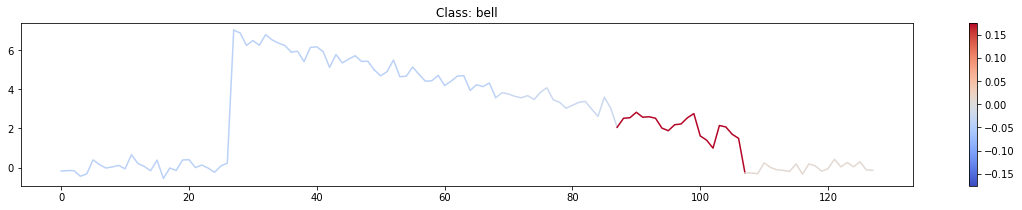

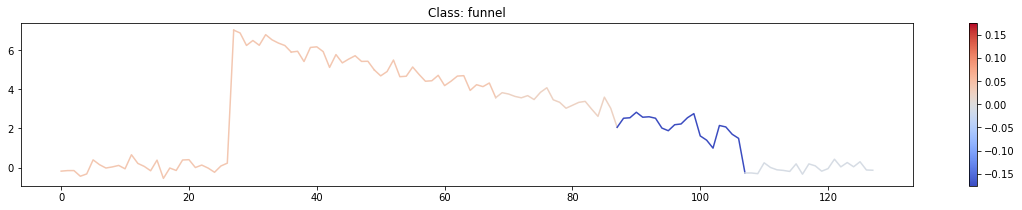

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.6s finished


rule
Rules used to predict sample 0: 
sample predicted class:  cylinder
decision id node 0 : (shapelet n. 0 (distance = 8.615809) > 1.1449636220932007)


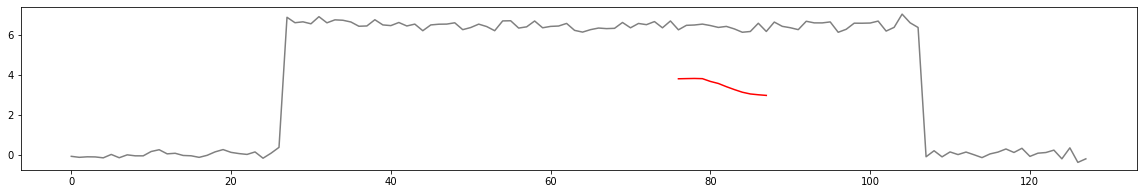

decision id node 0 : (shapelet n. 0 (distance = 8.615809) > 1.1449636220932007)


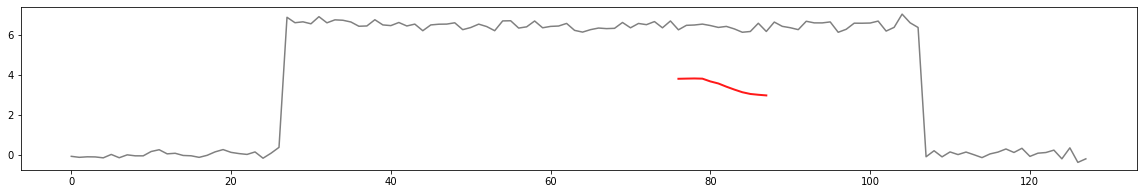

crule0
Rules used to predict sample 0: 
sample predicted class:  funnel
decision id node 0 : (shapelet n. 0 (distance = 0.055099487) <= 1.1449636220932007)
decision id node 1 : (shapelet n. 5 (distance = 4.3868284) > 2.9216067790985107)
decision id node 7 : (shapelet n. 6 (distance = 0.9719874) > 0.5496982336044312)


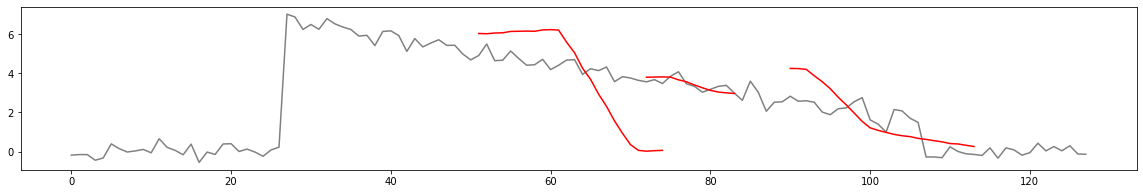

decision id node 0 : (shapelet n. 0 (distance = 0.055099487) <= 1.1449636220932007)


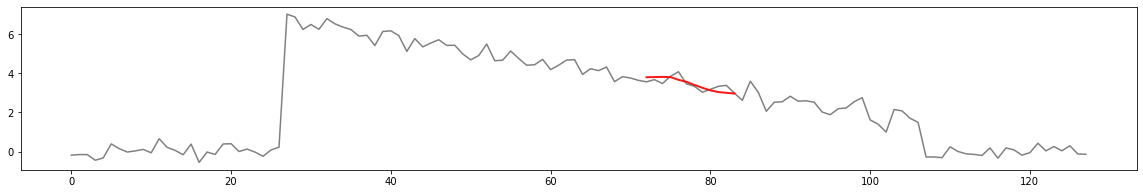

decision id node 1 : (shapelet n. 5 (distance = 4.3868284) > 2.9216067790985107)


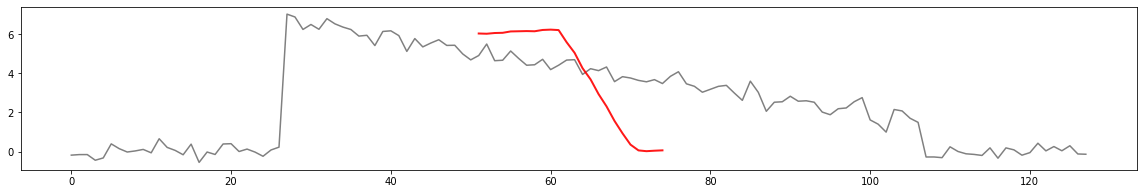

decision id node 7 : (shapelet n. 6 (distance = 0.9719874) > 0.5496982336044312)


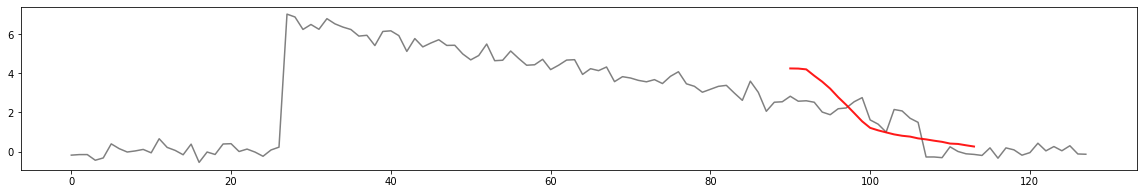

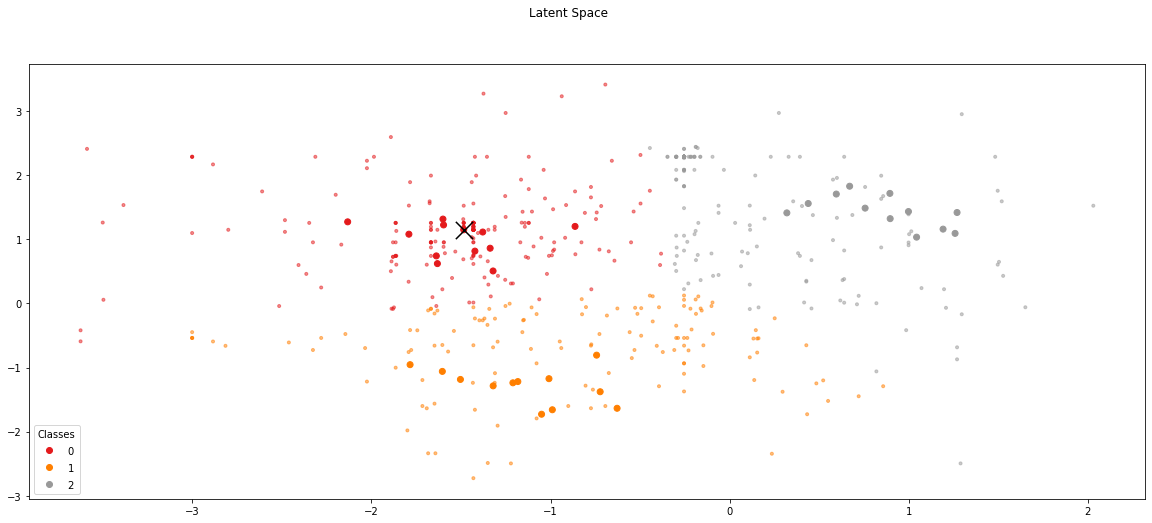

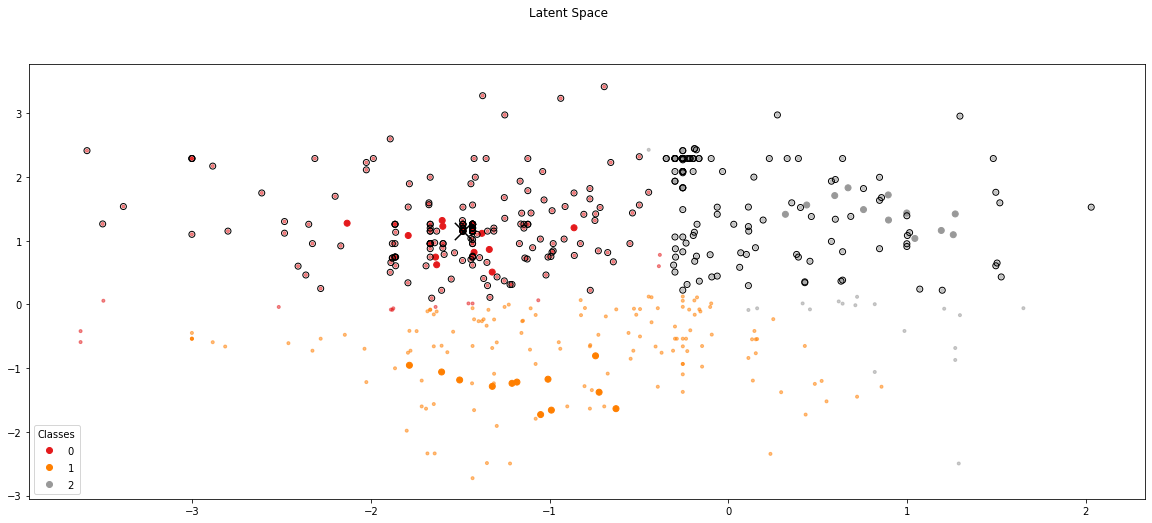

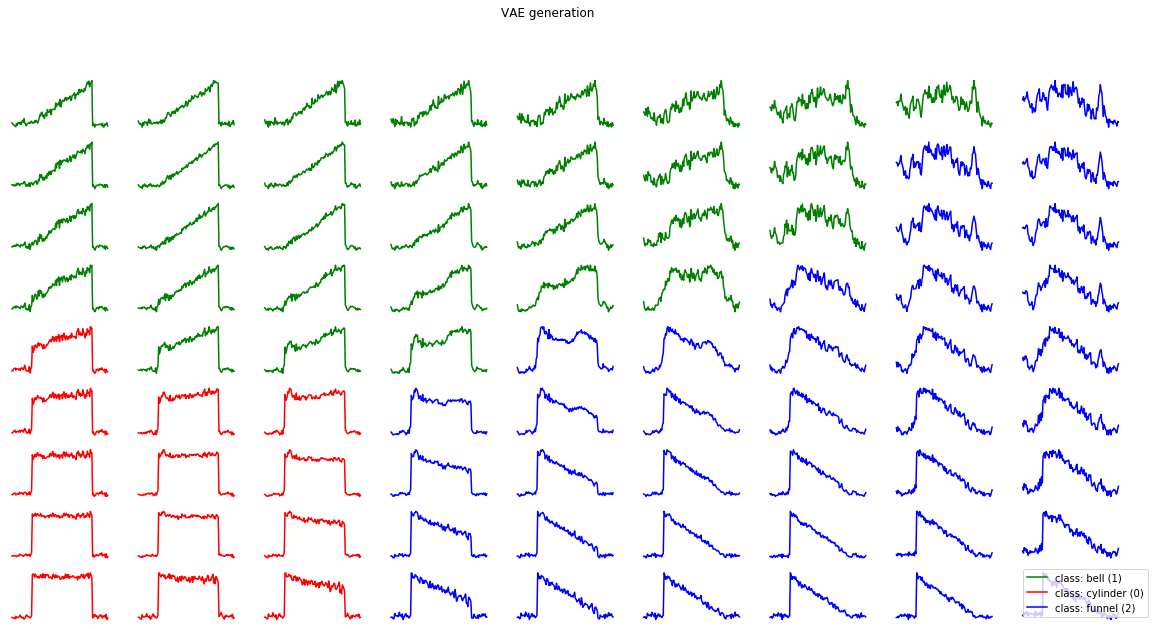

In [43]:
params = {"nsamples":1000, 
          "background":"linear_consecutive", 
          "pen":1, 
          "peltmodel":"rbf",
          "jump": 1,
          "graph_out_file":None,
          "shapelet_mapper":None, 
          "VAE_2d_grid_size":9,
          "max_iter":100}
agnostic.plot_explanation(rules = True,
                          heatmap = False,
                          shap_explanation = True,
                          shapelet_explanation = True,
                          figsize = (20,3),
                          VAE_2d = True,
                          **params
                         )